# House Sales Prediction

All the data for this analysis comes from a public Kaggle.com competition: 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data contains 80 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. This competition challenges you to predict the final price of each home.

Note that all variable descriptions are in the descriptions text file found on the link above.

---
# Attempt 1 - Naive Analysis
This attempt takes a broad look at the data. It includes all of the features and lets Ridge and Lasso take care of the feature engineering part rather than delve into each feature one by one. 

In this attempt, I followed many of the methodologies in the notebook below from a highly ranked Kaggle user:

https://www.kaggle.com/apapiu/regularized-linear-models

In [16]:
# dataframe and plot
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet

# Model Evaluation Metrics
from sklearn import metrics

house_train = pd.read_csv('data/house_train.csv')
house_test = pd.read_csv('data/house_test.csv')

In [17]:
house_train.shape

(1460, 81)

In [18]:
house_test.shape

(1459, 80)

In [19]:
# Check top 10 numeric features correlated with 'SalePrice' 
# I did this only because I liked the method, not really using it here at this point

# See the kaggle notebook below for this example
# https://www.kaggle.com/junyingzhang2018/ridge-regression-score-0-119

house_train.corr()['SalePrice'].sort_values(ascending=False).head(11)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

### Combine all features from both test and training sets so that there is no need to edit both separately 

In [20]:
# Note that 'Id' and 'SalePrice' columns are cut out on concat belwo.
# 'MSSubClass' is the first col and 'SaleCondition' is last col

all_data = pd.concat((house_train.loc[:, 'MSSubClass':'SaleCondition'],
                    house_test.loc[:, 'MSSubClass':'SaleCondition']))

In [21]:
all_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Check Label/Predictor Variable Distribution
Because we are performing regression analysis, we need our dependent y varibale ('SalePrice') to be normally distributed

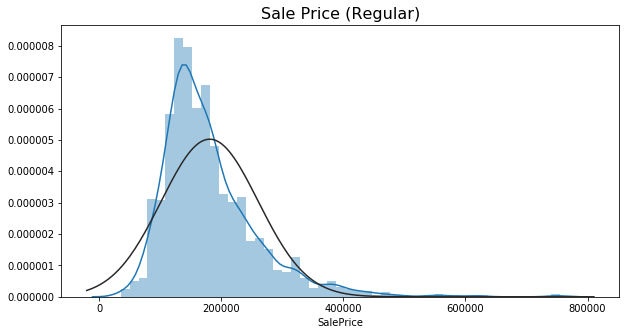

In [22]:
# histogram and normal probability plot

plt.figure(figsize=(10,5))
sns.distplot(house_train['SalePrice'], fit=scipy.stats.norm);
plt.title('Sale Price (Regular)', fontsize=16)
plt.show()

### Based on the visuals above'SalePrice is not normally distributed due to the large potential variations in house values. Therefore, transforming this data makes sense

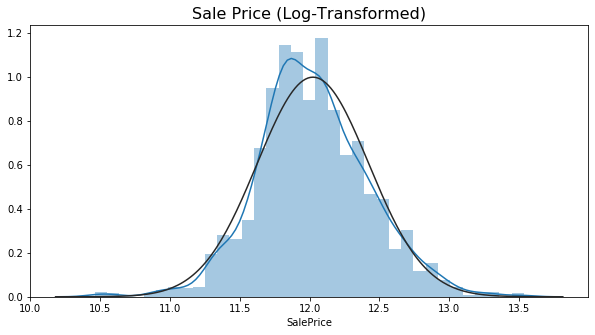

In [23]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(house_train['SalePrice']), fit=scipy.stats.norm);
plt.title('Sale Price (Log-Transformed)', fontsize=16)
plt.show()

In [24]:
house_train['SalePrice'].head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [25]:
house_train['SalePrice'] = np.log(house_train['SalePrice'])
house_train['SalePrice'].head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

### Double check the transformed values

In [26]:
np.exp(house_train['SalePrice']).head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

### Next I check only the numeric features for skewness and convert the ones that need converting based on a pre-defined skewness metric so that they can all be converted at once

In [27]:
# Get only the numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
print(numeric_feats.shape)
numeric_feats

(36,)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

### Note that np.log1p() is used here instead of np.log() to transform the data. This is because there are null or 0 values in the data which np.log1p() can handle whereas np.log() throws an error

In [28]:
#compute skewness then log transform all skewed columns 
skewed_feats = house_train[numeric_feats].skew()
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [29]:
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [30]:
all_data.shape

(2919, 79)

### Below I create dummy variables for all of the text features which increases the column count from 79 to 288

In [21]:
all_data =  pd.get_dummies(all_data)

In [22]:
all_data.shape

(2919, 288)

In [23]:
all_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.081404,3.091042,7.568896,4,7,1970,1970,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,1,0
1455,5.081404,3.091042,7.546974,4,5,1970,1970,0.000000,5.533389,0.0,...,0,0,0,1,1,0,0,0,0,0
1456,3.044522,5.081404,9.903538,5,7,1960,1996,0.000000,7.110696,0.0,...,0,0,0,1,1,0,0,0,0,0
1457,4.454347,4.143135,9.253591,5,5,1992,1992,0.000000,5.823046,0.0,...,0,0,0,1,0,0,0,0,1,0


### Fill all na's with mean value of column

In [24]:
# All Null Columns
nulls = all_data.isnull().sum()
nulls[nulls != 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [25]:
all_data = all_data.fillna(all_data.mean())

### All null values have been removed and the data has been cleaned.

### Next I convert 'all_data'  back into the original training and test sets since all editing is finished

In [26]:
X_train = all_data[: house_train.shape[0]]
X_test = all_data[house_train.shape[0] :]
y = house_train['SalePrice']

### Cross Validation testing Using RMSE as scoring factor
Note that cross-validation is a scoring parameter in sklearn, there are 3 different API's for evaluating the quality of a model's predictions.
* cv = the number of subdivisions the data is divided into and tested
* scoring is the error metric being tested, see link below for explanations

For more info on scoring parameters and model evaluation see:

https://scikit-learn.org/stable/modules/model_evaluation.html

The below links explain the reasoning behind the negative scoring methodology:

https://www.kaggle.com/dansbecker/cross-validation

https://stackoverflow.com/questions/48244219/is-sklearn-metrics-mean-squared-error-the-larger-the-better-negated#48246255

In [27]:
# Note that scoring input 'neg_mean_squared_error' is really just
# the negative of the mean_squared_error

# This is done because there are many types of model accuracy 
# checks where some require max values as best scores and some
# the min values. 

# Scikit-learn has a convention where all metrics are defined so 
# a high number is better. Using negatives here allows them to be 
# consistent with that convention, though negative MAE is almost 
# unheard of elsewhere.

# Therefore, when using cross-validation scoring, negative is used
# in cases where the min score is ideal rather than max score

# Note that mean_squared_error returns negative values and because 
# one can't take the sqrt of a negative number, -cross_val_score is 
# used to turn the scores positive so that the sqrt can be calculated. 

# Note that both methods work the same below, the cv function
# DOES NOT have a regular mean_squared_error function, thus the 
# reason why the neg_mean_squared_error results have to be turned positive
# using the negtive sign

# cv is the # of subdivisions the data is divided into and tested
# scoring is the error metric being tested

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, 
                                    X_train,
                                    y, 
                                    scoring='neg_mean_squared_error', 
                                    cv = 5))
    return(rmse)


def rmse_cv(model):
    rmse = cross_val_score(model, 
                           X_train,
                           y, 
                           scoring='neg_mean_squared_error', 
                           cv = 5)
    return(np.sqrt(-rmse))

### Ridge Regression Model Test
Multiple alphas are tested in order to determine the ideal value to produce the best results. Note that each alpha is inputed into its own model that is then cross-validated with the rmse_cv function created above

In [28]:
model_Ridge = Ridge()

test_alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in test_alphas]

print(f'All Cross-Validations Scores:\n{cv_ridge}\n')
print(f'Cross-Validation Mean Score: {np.mean(cv_ridge)}\n')
print(f'Min CV Score: {np.min(cv_ridge)}')

All Cross-Validations Scores:
[0.13893742611897414, 0.13777642028624817, 0.13501534646763005, 0.13136282589292544, 0.12864988226673474, 0.1278227540848166, 0.12733830985713235, 0.12753037363346023, 0.1289598645336085, 0.13099537471783448, 0.13316467272236693]

Cross-Validation Mean Score: 0.1315957500528847

Min CV Score: 0.12733830985713235


Text(0, 0.5, 'rmse')

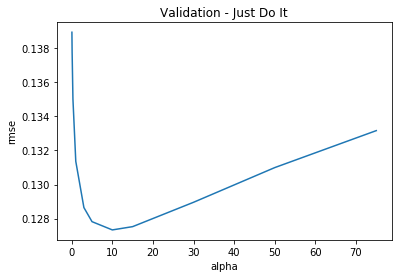

In [29]:
cv_ridge = pd.Series(cv_ridge, index = test_alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

### For the ridge regression model, the ideal alpha is at 10, where the rmse is minimized at 0.1273

### Next the LassoCV Regression model is used
For high-dimensional datasets with many collinear features, LassoCV is most often preferable.

Note that LassoCV stands for Lasso Cross Validation

In [30]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [31]:
rmse_cv(model_lasso).mean()

0.12256827411134738

In [32]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " + 
      str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


### Next Determine the best and worst features by coefficient values (top/bottom 10)

In [33]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

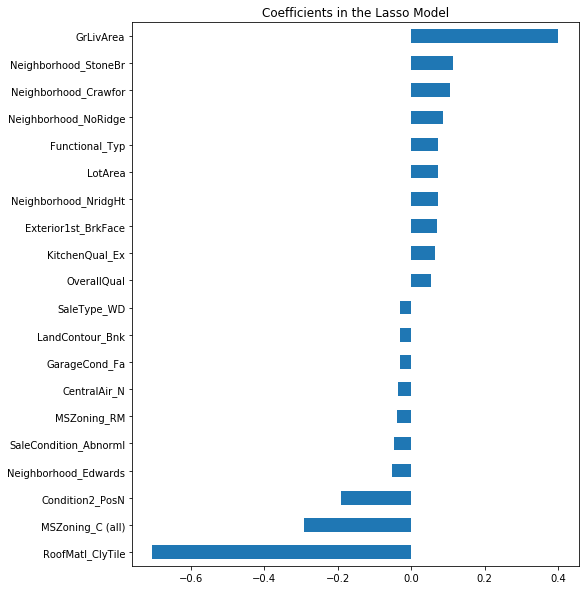

In [34]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### The most important feature by far is 'GrLivArea' also note that location is extemely important as 4 of the neighborhoods are included in the top 10

### Next an error/residual chart is created to check for homoscedacisity. 

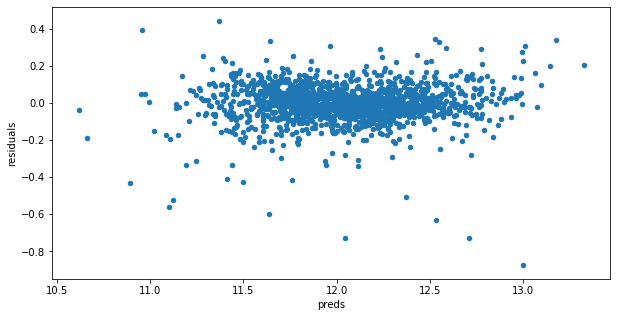

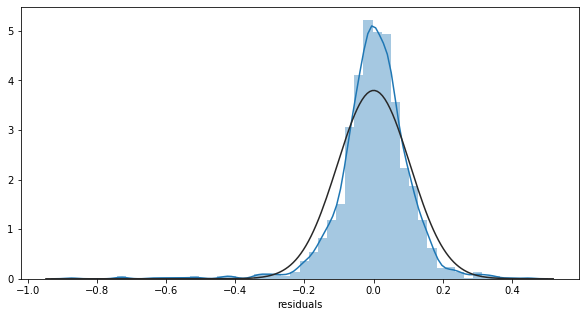

In [36]:
# Residual Check:
plt.rcParams['figure.figsize'] = (10.0, 5.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")
plt.show()

sns.distplot(preds['residuals'], fit=scipy.stats.norm);
plt.show()

### The 'shotgun blast' look of the scatter plot is good as there is sufficient randomness to the patterns and the residuals are normally distributed as we would hope to see

### Next I take the training data and run a model with a test/train split set to see if the results come close to the mean RMSE above and to get the average price error value

In [37]:
X = all_data[: house_train.shape[0]]
y = house_train['SalePrice']

print(X.shape)
print(y.shape)
print()

# Ridge Regression Model
ridge2 = Ridge(alpha=10)

# Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=100)
ridge2.fit(X_train, y_train)
y_pred_lin = ridge2.predict(X_test)



print('Ridge Regression Results:')
print('----------------------------------------')
# MAE
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred_lin)}')

# RMSE
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin))}')

(1460, 288)
(1460,)

Ridge Regression Results:
----------------------------------------
MAE: 0.08824790972080403
RMSE: 0.13176794428306896


In [38]:
actuals_conv = np.exp(y_test)
pred_conv = np.exp(y_pred_lin)

In [39]:
actuals_conv

1436    120500.0
57      196500.0
780     176000.0
382     213500.0
1170    171000.0
          ...   
398      67000.0
165     127500.0
213     156000.0
950     129000.0
552     255500.0
Name: SalePrice, Length: 365, dtype: float64

In [40]:
pred_conv

array([111028.79891484, 195426.72737469, 168411.66078951, 203528.36637731,
       107842.02897755, 288851.07400523, 226107.87821758, 281342.6828319 ,
       100365.11578751, 165626.49320869, 198767.93602009, 205582.18568419,
       151086.75110771, 243772.48714398, 104592.76892522, 133213.28314334,
       180320.19410182, 112111.17042022, 119769.88977606, 118727.70296552,
       169136.47983669, 109551.9555098 , 142691.987559  , 122571.94278993,
       186598.4364645 , 134528.04019629,  46969.65960587,  90758.3541213 ,
       197379.26408358, 152525.12820367, 148123.17037919, 200204.21343715,
       235763.56601887,  91851.2376366 , 124416.26292977,  75899.77061024,
       124820.1851465 ,  79138.31197009, 141173.05626699, 115994.60943235,
       372395.6174629 , 215359.59124792, 119313.23716729,  76994.5289848 ,
       171938.91844442,  71015.11019551, 217171.50328895, 128889.60921864,
       146085.21451898, 107290.62917513, 196473.93278929, 111642.24141674,
       296757.90201803, 2

In [41]:
res_conv = actuals_conv - pred_conv

abs(res_conv).mean()

15667.498943425853

### So the average pricing error is 15.7k which isn't all that great. Ideally I would want it below 10k, especially for houses prices under the 150k range. 

In [42]:
err1 = len(res_conv[abs(res_conv) < 10_000])

print(f'Errors Under $10,000: {err1} or {round(err1/len(y_test),4)*100}%')

Errors Under $10,000: 181 or 49.59%


In [43]:
err2 = len(res_conv[abs(res_conv) > 25_000])

print(f'Errors Over $25,000: {err2} or {round(err2/len(y_test),4)*100}%')

Errors Over $25,000: 53 or 14.52%


### Only half of the results were acceptable (by me at < 10k error on average)

### Around 14.5% of the results were > 25k which is not acceptable. The extreme outlier results need to be inspected 

### Because this was just a broad quick analysis, the results are actually a good start. Most likely some outliers and/or unessary highly collinear features are sneaking through (especially with Ridge). Therefore I will delve into 

---

# Re-Try Attempt 1 with only top 10 most important features

From the above analysis I only want to keep the top 10 featuers and see if the results improve here are the features I'm going to keep:
1. 'GrLivArea' (Numerical)
2. 'Neighborhood' (Text/Categorical)
3. 'Functional' (Text/Categorical)
4. 'LotArea' (Numerical)
5. 'Exterior1st' (Text/Categorical)
6. 'KitchenQual' (Text/Categorical)
7. 'OverallQual' (Numerical)
8. 'BsmtQual' (Text/Categorical)
9. 'Condition1' (Text/Categorical)
10. 'OverallCond' (Numerical)

In [44]:
house_train = pd.read_csv('data/house_train.csv')
house_test = pd.read_csv('data/house_test.csv')

In [45]:
all_data = pd.concat((house_train.loc[:, 'MSSubClass':'SaleCondition'],
                      house_test.loc[:, 'MSSubClass':'SaleCondition']))

In [46]:
all_data = all_data[['GrLivArea','Neighborhood',
                    'Functional', 'LotArea',
                    'Exterior1st', 'KitchenQual',
                    'OverallQual', 'BsmtQual',
                    'Condition1', 'OverallCond']]

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   GrLivArea     2919 non-null   int64 
 1   Neighborhood  2919 non-null   object
 2   Functional    2917 non-null   object
 3   LotArea       2919 non-null   int64 
 4   Exterior1st   2918 non-null   object
 5   KitchenQual   2918 non-null   object
 6   OverallQual   2919 non-null   int64 
 7   BsmtQual      2838 non-null   object
 8   Condition1    2919 non-null   object
 9   OverallCond   2919 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 250.9+ KB


In [48]:
# Get only the numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Transform skewed variables
house_train['SalePrice'] = np.log(house_train['SalePrice'])

skewed_feats = all_data[numeric_feats].skew()
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [49]:
all_data =  pd.get_dummies(all_data)

In [50]:
all_data.shape

(2919, 68)

In [51]:
# Check nulls, there are none so move on

nulls = all_data.isnull().sum()
nulls[nulls != 0]

Series([], dtype: int64)

In [52]:
X_train = all_data[: house_train.shape[0]]
X_test = all_data[house_train.shape[0] :]
y = house_train['SalePrice']

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, 
                                  X_train,
                                  y, 
                                  scoring='neg_mean_squared_error', 
                                  cv = 5))
    return(rmse)

In [56]:
model_Ridge = Ridge()

test_alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in test_alphas]

print(np.mean(cv_ridge))

0.14996026212730315


### So only using the top 10 fetures causes underfitting and produces worse results

### Below is a good set up for running 4 models at once

In [57]:
# Build Models
lin = LinearRegression()
ridge = Ridge(alpha = 1.0)
las = Lasso(alpha = 1.0)
enet = ElasticNet(alpha = 1.0)

# Fit Models with the training data
lin.fit(X_train, y_train)
ridge.fit(X_train, y_train)
las.fit(X_train, y_train)
enet.fit(X_train, y_train)

# Make Sales Predictions
y_pred_lin =   lin.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_las = las.predict(X_test)
y_pred_enet = enet.predict(X_test)


# Results 

print('Linear Regression Results')
# MAE
print(metrics.mean_absolute_error(y_test, y_pred_lin))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin)))

print()

print('Ridge Regression Results')
# MAE
print(metrics.mean_absolute_error(y_test, y_pred_ridge))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

print()

print('Lasso Regression Results')
# MAE
print(metrics.mean_absolute_error(y_test, y_pred_las))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_las)))

print()

print('Elastic-Net Regression Results')
# MAE
print(metrics.mean_absolute_error(y_test, y_pred_enet))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_enet)))

NameError: name 'Lasso' is not defined